# Analyse ESG et rendements : clustering, tests et robustesse

### À partir de :  
### *K-means et analyse de clustering hiérarchique agglomératif des scores ESG, variations annuelles et rendements boursiers : perspectives du secteur de l’énergie en Europe et aux États-Unis*  
**Ștefan Rusu, Marcel Ioan Boloș, Marius Leordeanu (2023)**



Ce notebook propose une **reproduction et une amélioration** de l’étude présentée dans le papier de référence, appliquée à un **nouvel univers d’investissement** : 18 entreprises de la supply chain de NVIDIA, à partir de données Bloomberg BESG sur la période 2016–2026.

Le projet reprend la méthodologie initiale (K-means et clustering hiérarchique agglomératif), puis introduit plusieurs **améliorations méthodologiques** afin d’obtenir une analyse plus robuste :
- **standardisation par Z-score** pour corriger les problèmes d’échelle,
- **réduction de dimension par ACP** pour la visualisation,

L’objectif n’est pas d’établir une relation causale entre ESG et rendements, mais de **mieux comprendre la structure des données**, d’identifier d’éventuels groupes d’entreprises, et d’évaluer la sensibilité des résultats aux choix méthodologiques et à l’univers étudié.


---

## 1. Contexte général et sources de données

L’analyse repose sur deux sources principales de données :

- **Données ESG** : issues de Bloomberg (BESG), comprenant :
  - le score Environmental,
  - le score Social,
  - le score ESG global (composite).
- **Données de marché** : issues de **Yahoo Finance**, à partir des prix ajustés (Adjusted Close), utilisés pour calculer les rendements boursiers.

L’échantillon initial est composé de 23 entreprises du secteur technologique / IA / semi-conducteurs, observées sur la période 2016–2026 à une fréquence mensuelle.

---

## 2. Prétraitement des données ESG

Avant ce notebook, un premier travail de nettoyage approfondi a été réalisé sur les données ESG Bloomberg. Ce prétraitement comprend :

- La **conversion des dates** depuis le format Excel numérique de Bloomberg vers un format `datetime` exploitable (en utilisant la base 30/12/1899).

- L’**harmonisation des séparateurs décimaux** (virgule → point) et la conversion des colonnes de scores en format numérique.

- Le **traitement des valeurs manquantes spécifiques à Bloomberg** (par exemple `#N/A N/A`, `N/A`, etc.).

- La **restructuration des données** du format large (une colonne par entreprise) vers un format long (une ligne par observation date/entreprise), afin de faciliter les analyses statistiques et les visualisations.

- La **fusion des trois types de scores** (Environmental, Social et ESG global) dans un unique DataFrame panel de type *(Date × Entreprise)*.

À l’issue de cette étape, on dispose d’un panel ESG propre, cohérent et exploitable pour les analyses ultérieures.

---

## 3. Analyse et traitement des valeurs manquantes ESG

L’analyse des valeurs manquantes est une étape fondamentale avant toute modélisation. 

Dans le contexte des scores ESG Bloomberg, les valeurs manquantes ne sont généralement pas MCAR (*Missing Completely At Random*), mais majoritairement **structurelles** : elles correspondent le plus souvent à des périodes où le score n’était pas encore disponible pour l’entreprise concernée.

Ce phénomène est courant, car les scores ESG ne sont pas nécessairement calculés dès l’introduction en bourse et apparaissent progressivement au fil du temps.

On distingue notamment :

- Les **valeurs manquantes en début de série** (*left-censoring*) : le score n’existait pas encore pour l’entreprise.

- Les **valeurs manquantes sporadiques** : pouvant correspondre à des périodes de recalcul, de transition méthodologique ou à des problèmes de données.

Dans un souci de robustesse statistique, les entreprises présentant un taux de valeurs manquantes trop élevé ont été exclues de l’analyse, afin d’éviter que les résultats ne soient dominés par quelques séries très incomplètes.

Les entreprises retirées de l’échantillon sont :

- Fabrinet  
- Snowflake  
- CREDO Technology  
- Siemens Energy  
- Elite Material  

---

## 4. Données financières et fusion des bases

Les rendements boursiers sont importés depuis **Yahoo Finance** à partir des prix ajustés (*Adjusted Close*). 

Pour chaque entreprise :

- Les séries de prix sont téléchargées,
- Les rendements sont calculés à partir des prix,
- Les données sont agrégées à une fréquence mensuelle,
- Les rendements sont ensuite **alignés temporellement** avec les données ESG Bloomberg.

Les deux sources (ESG et rendements) sont ensuite **fusionnées par date et par entreprise** afin d’obtenir une base commune cohérente pour l’analyse conjointe.

---

## 5. Objectifs :

- Standardiser (Z-score) pour comparer ESG et rendements sur une base commune.

- Determiner le nombre de clusters via coude + silhouette (K-means).

- Visualiser et interpreter les clusters (PCA, profils).

- Evaluer l'effet ESG par tests statistiques et regressions robustes.

### PLAN 

1. Charger les donnees ESG + rendements
2. Contrôle qualité et exploration (EDA) du panel fusionné ESG + rendements

    A. Couverture temporelle et valeurs manquantes

    B. Statistiques descriptives et distributions

    C. Détection des valeurs extrêmes (outliers)

    D. Relations entre ESG et rendements

3. Limites méthodologiques et corrections apportées 

4. Pourquoi la standardisation (Z-score) ?

5. Visualisations ESG vs rendements

    A. Corrélation ESG/rendement

    B. Scatter avec tendance

    C. Rendement moyen par quartile ESG

    D. Série temporelle annuelle moyenne ESG vs rendement

6. K-means : méthode du coude et silhouette

7. K-means final et visualisation (ACP)

8. Régressions simples (effet ESG sur rendement)





In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

sns.set_theme(style='whitegrid')

## 1. Charger les donnees ESG + rendements

On utilise `data/clean/notebook4/panel_esg_returns.csv` généré par le notebook 04.


Note : le panel est annualisé (une ligne par entreprise et par année), aligné sur fin d'année.

In [3]:
# Resolve project root via pyproject.toml
p = Path.cwd()
project_root = None
for _ in range(6):
    if (p / 'pyproject.toml').exists():
        project_root = p
        break
    if p.parent == p:
        break
    p = p.parent

if project_root is None:
    raise FileNotFoundError('pyproject.toml not found; cannot locate project root')

data_path = project_root / 'data/clean/notebook4/panel_esg_returns.csv'
if not data_path.exists():
    raise FileNotFoundError('panel_esg_returns.csv not found. Run notebook 04 first.')

df = pd.read_csv(data_path)
df['Date'] = pd.to_datetime(df['Date'])
df.head()


,Date,Ticker,Env_Score,Soc_Score,ESG_Score,Entreprise,Yahoo_Ticker,Return
0,2015-12-31,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,NaN
1,2016-01-31,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,NaN
2,2016-02-29,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,0.098901
3,2016-03-31,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,-0.061667
4,2016-04-30,000660 KS Equity,2.94,2.84,3.47,SK Hynix,000660.KS,0.000000


### Lecture des données

Le tableau chargé contient les scores ESG annuels par entreprise (une observation par année) et les rendements annuels en fin d'année.
Il constitue la base de toute l'analyse :

**Objectif : Voir si, à données comparables, les rendements se structurent selon les niveaux ESG.**


## 2. Contrôle qualité et exploration (EDA) du panel fusionné ESG + rendements

Après la fusion des données ESG et financières, un diagnostic complet du panel est réalisé afin de s’assurer de la fiabilité de la base finale et de comprendre la structure des données avant toute standardisation et modélisation.

Cette étape joue un double rôle :
- (i) **Contrôle qualité** : vérifier la complétude et la cohérence du dataset,
- (ii) **Exploration des données (EDA)** : analyser la distribution, la dispersion et la présence d’anomalies ou d’outliers.

En pratique, les analyses suivantes sont menées :

A. Couverture temporelle et valeurs manquantes
B. Statistiques descriptives et distributions
C. Détection des valeurs extrêmes (outliers)
D. Relations entre ESG et rendements

### A. Couverture temporelle et valeurs manquantes

On commence par mesurer :
- le **taux global de rendements manquants** dans le dataset,
- la **période effectivement couverte** (date de début et date de fin après fusion),
- ainsi que l’**hétérogénéité des valeurs manquantes par entreprise** (par ticker).

Le taux global de rendements manquants fournit une première indication sur la solidité du panel. Une proportion trop élevée de valeurs manquantes réduirait la taille effective de l’échantillon et pourrait biaiser les analyses ultérieures.  
L’analyse par ticker permet d’identifier si les valeurs manquantes sont concentrées sur quelques entreprises seulement. Dans ce cas, ces séries incomplètes peuvent dominer artificiellement les moyennes, les corrélations ou la formation des clusters. Une restriction de la fenêtre temporelle ou l’exclusion de certains titres peut alors être justifiée afin de stabiliser les résultats.

On complète ce diagnostic par un résumé du **pourcentage de valeurs manquantes par variable** et par une **visualisation sous forme de heatmap**, ce qui permet d’avoir une vue d’ensemble de la structure des données manquantes sur l’ensemble du panel fusionné.


In [4]:
missing_return_pct = df['Return'].isna().mean() * 100
date_min, date_max = df['Date'].min(), df['Date'].max()
print('Missing Return %:', round(missing_return_pct, 2))
print('Date range:', date_min.date(), '->', date_max.date())

missing_by_ticker = (
    df.groupby('Yahoo_Ticker')['Return']
    .apply(lambda s: s.isna().mean())
    .sort_values(ascending=False)
)
missing_by_ticker.head(10)


Missing Return %: 0.96
Date range: 2015-12-31 -> 2026-01-31


Yahoo_Ticker
000660.KS    0.016393
9984.T       0.016393
6857.T       0.016393
META         0.008197
TSLA         0.008197
TSEM         0.008197
NVDA         0.008197
MU           0.008197
MSFT         0.008197
MPWR         0.008197
Name: Return, dtype: float64

Pourcentage de valeurs manquantes par variable:


Return          0.956284
Date            0.000000
Ticker          0.000000
Env_Score       0.000000
Soc_Score       0.000000
ESG_Score       0.000000
Entreprise      0.000000
Yahoo_Ticker    0.000000
dtype: float64

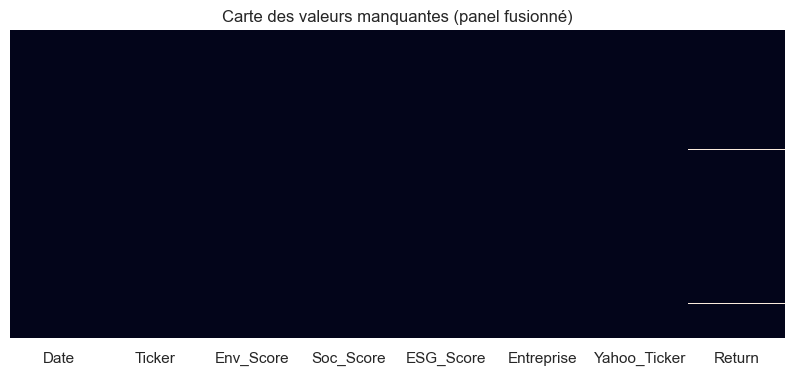

In [5]:
# Aperçu des valeurs manquantes sur toutes les variables
missing_summary = df.isna().mean().sort_values(ascending=False) * 100
print('Pourcentage de valeurs manquantes par variable:')
display(missing_summary)

# Heatmap des valeurs manquantes
plt.figure(figsize=(10, 4))
sns.heatmap(df.isna(), cbar=False, yticklabels=False)
plt.title('Carte des valeurs manquantes (panel fusionné)')
plt.show()

In [6]:
# Nombre de lignes avec au moins un NaN
n_nan_rows = df.isna().any(axis=1).sum()
print(f"Nombre de lignes contenant au moins un NaN : {n_nan_rows}")

# Part du dataset
print(f"Pourcentage de lignes affectées : {100 * n_nan_rows / len(df):.2f}%")

df_clean = df.dropna(subset=['Return']).copy()

print("Taille avant nettoyage :", df.shape)
print("Taille après nettoyage :", df_clean.shape)

df = df_clean.copy()

Nombre de lignes contenant au moins un NaN : 21
Pourcentage de lignes affectées : 0.96%
Taille avant nettoyage : (2196, 8)
Taille après nettoyage : (2175, 8)


### B. Statistiques descriptives et distributions

Une fois la qualité générale de la base vérifiée, on procède à une exploration statistique classique :

- Calcul des **statistiques descriptives** (moyenne, médiane, minimum, maximum, écart-type) pour toutes les variables numériques (scores ESG et rendements).
- Analyse des éventuelles **variables catégorielles** (si présentes) via leurs distributions de fréquence.
- Visualisation des **distributions** des principales variables (Environmental Score, Social Score, ESG global et rendements) à l’aide d’histogrammes et de densités, afin d’évaluer :
  - la forme des distributions (asymétrie, queues épaisses, bimodalité),
  - la dispersion relative des variables,
  - et la comparabilité des échelles.

Ces graphiques permettent de mieux comprendre la structure statistique des données avant toute transformation (notamment la standardisation).


In [33]:
# Statistiques descriptives pour toutes les variables numériques
print('Statistiques descriptives :')
display(df.describe().T)

# Statistiques pour les variables catégorielles (si présentes)
cat_cols = df.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    for col in cat_cols:
        print(f"\nDistribution de {col} :")
        print(df[col].value_counts().head(10))

Statistiques descriptives :


,count,mean,min,25%,50%,75%,max,std
Date,2196,2021-01-14 04:55:04.918032896,2015-12-31 00:00:00,2018-06-30 00:00:00,2021-01-15 12:00:00,2023-07-31 00:00:00,2026-01-31 00:00:00,NaN
Env_Score,2196.0,4.092928,0.0,2.67,4.35,5.73,7.61,2.146201
Soc_Score,2196.0,3.17485,0.63,1.86,2.59,4.39,7.91,1.723884
ESG_Score,2196.0,4.273206,1.67,3.24,4.19,5.25,7.07,1.395964
Return,2175.0,0.033581,-0.446203,-0.043033,0.022248,0.097211,0.78,0.124251



Distribution de Ticker :
Ticker
000660 KS Equity    122
6857 JP Equity      122
TSLA US Equity      122
TSEM IT Equity      122
NVDA US Equity      122
MU US Equity        122
MSFT US Equity      122
MPWR US Equity      122
META US Equity      122
LRCX US Equity      122
Name: count, dtype: int64

Distribution de Entreprise :
Entreprise
SK Hynix                    122
Advantest                   122
Tesla                       122
Tower Semiconductor         122
NVIDIA                      122
Micron Technology           122
Microsoft                   122
Monolithic Power Systems    122
Meta Platforms              122
Lam Research                122
Name: count, dtype: int64

Distribution de Yahoo_Ticker :
Yahoo_Ticker
000660.KS    122
6857.T       122
TSLA         122
TSEM         122
NVDA         122
MU           122
MSFT         122
MPWR         122
META         122
LRCX         122
Name: count, dtype: int64


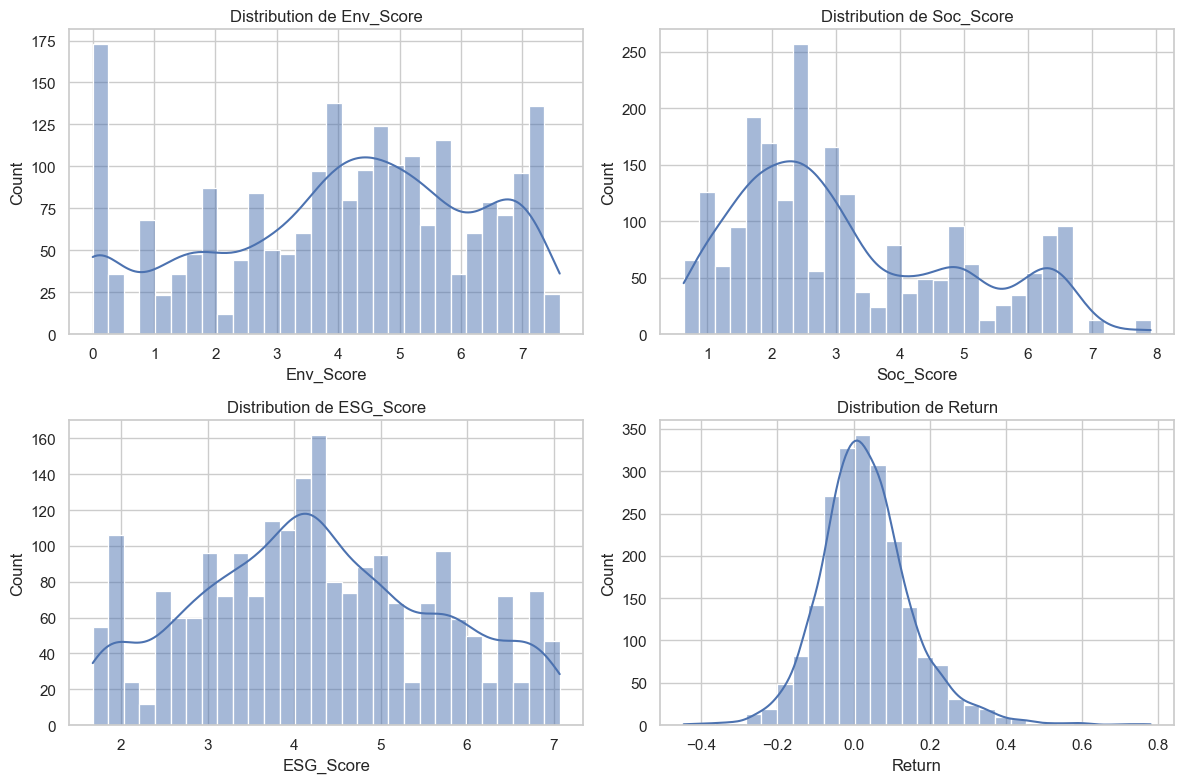

In [34]:
# Histogrammes pour les principales variables
num_cols = ['Env_Score', 'Soc_Score', 'ESG_Score', 'Return']
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribution de {col}')
plt.tight_layout()
plt.show()

### C. Détection des valeurs extrêmes (outliers)

On analyse ensuite la présence d’outliers à l’aide de :
- **Boxplots** pour une visualisation rapide des valeurs extrêmes,
- et d’une règle basée sur l’**écart interquartile (IQR)** pour compter le nombre d’observations extrêmes par variable.

Cette étape est importante car :
- les rendements financiers présentent souvent des queues épaisses et des valeurs extrêmes,
- les scores ESG peuvent également contenir des observations atypiques liées à des changements méthodologiques ou à des événements spécifiques,
- et ces outliers peuvent influencer de manière disproportionnée les distances utilisées dans les méthodes de clustering.


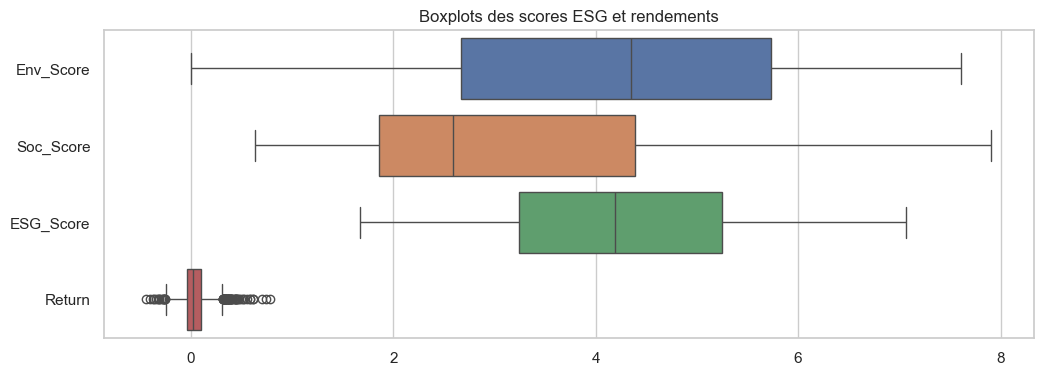

In [35]:
# Boxplots pour détecter les outliers
plt.figure(figsize=(12, 4))
sns.boxplot(data=df[num_cols], orient='h')
plt.title('Boxplots des scores ESG et rendements')
plt.show()

### D. Relations entre ESG et rendements

Enfin, on explore les relations bivariées entre les scores ESG (Environmental, Social, ESG global) et les rendements à l’aide de **scatterplots**.  
L’objectif est de :
- détecter visuellement d’éventuelles relations (linéaires ou non),
- évaluer la dispersion des points,
- et vérifier s’il existe une structure évidente avant l’application de méthodes de segmentation plus formelles.


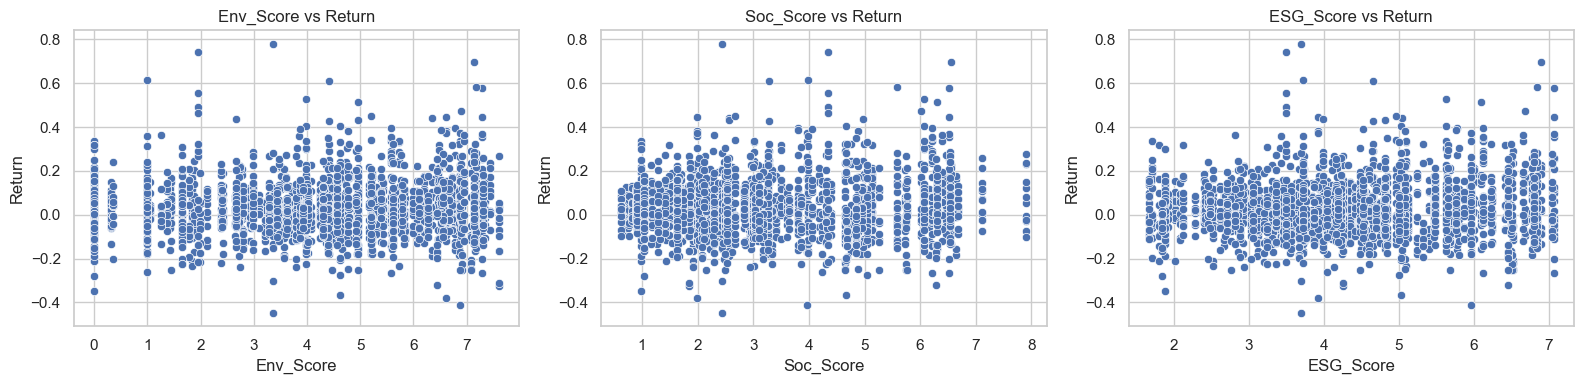

In [36]:
# Scatterplots ESG vs Return
plt.figure(figsize=(16, 4))
for i, col in enumerate(['Env_Score', 'Soc_Score', 'ESG_Score']):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=df[col], y=df['Return'])
    plt.xlabel(col)
    plt.ylabel('Return')
    plt.title(f'{col} vs Return')
plt.tight_layout()
plt.show()

In [37]:
# Analyse simple des outliers (valeurs extrêmes)
outlier_summary = {}
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    n_outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = n_outliers
print('Nombre de valeurs extrêmes détectées par variable :')
print(outlier_summary)

Nombre de valeurs extrêmes détectées par variable :
{'Env_Score': np.int64(0), 'Soc_Score': np.int64(0), 'ESG_Score': np.int64(0), 'Return': np.int64(75)}


## 3. Limites méthodologiques et corrections apportées

### => Rappel des limites tirées du paper

L’analyse exploratoire du panel fusionné ESG + rendements met en évidence plusieurs limites méthodologiques, déjà discutées dans le premier notebook, et motive les choix effectués dans la suite de l’analyse.

### Limite 1 : Biais d’échelle (domination de la variance)

L’ajout des rendements boursiers, dont la variance est bien supérieure à celle des scores ESG, implique que sans transformation préalable, la variable rendement dominerait totalement la formation des clusters lorsque des distances euclidiennes sont utilisées.

*Correction appliquée :*
•⁠  ⁠Standardisation Z-score de toutes les variables (scores ESG et rendements) avant toute analyse multivariée ou clustering.

---

### Limite 2 : Structure des données et hypothèses du clustering

Les distributions des scores ESG ne sont ni gaussiennes ni sphériques (présence de bimodalité, d’asymétrie et de queues épaisses). Or, l’algorithme K-means suppose implicitement des clusters convexes et de tailles comparables, ce qui est potentiellement mal adapté à la structure réelle de nos données.


•⁠  ⁠Utilisation de l’*Analyse en Composantes Principales (ACP)* pour visualiser la structure multidimensionnelle des données.


---

### Synthèse

L’analyse exploratoire du panel fusionné ESG + rendements confirme la nécessité de :

1.⁠ ⁠*Standardiser* toutes les variables avant toute analyse multivariée,
2.⁠ ⁠*Désagréger les piliers ESG* (Environmental, Social, ESG global) plutôt que de se limiter à un score agrégé,
3.⁠ ⁠*Utiliser des méthodes robustes* à la structure réelle des données (DBSCAN, ACP, corrélation de Spearman).

Ces choix méthodologiques permettent de limiter les biais identifiés dans la littérature et d’obtenir une analyse plus fiable et plus interprétable de la relation entre ESG et rendements.

## 4) Pourquoi la standardisation (Z-score) ?

Les rendements ont une volatilite beaucoup plus forte que les scores ESG.
Sans standardisation, les distances seraient presque entierement pilotees par les rendements.
On applique donc un Z-score sur toutes les features.


In [30]:
features = ['Env_Score', 'Soc_Score', 'ESG_Score', 'Return']
panel = df.dropna(subset=features).copy()

# Comparaison des echelles avant standardisation
desc = panel[features].describe().T[['mean','std','min','max']]
desc


,mean,std,min,max
Env_Score,4.211692,2.139884,0.000000,7.61000
Soc_Score,3.298923,1.731197,0.630000,7.91000
ESG_Score,4.382256,1.378325,1.710000,7.07000
Return,0.477233,0.823226,-0.650315,7.43437


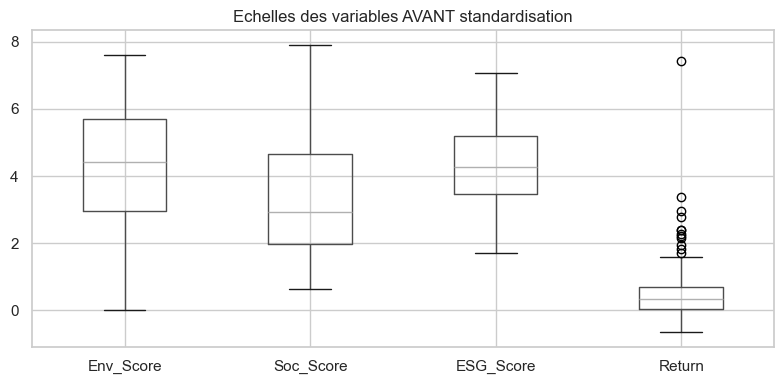

In [31]:
plt.figure(figsize=(8,4))
panel[features].boxplot()
plt.title('Echelles des variables AVANT standardisation')
plt.tight_layout()
plt.show()


### Lecture des echelles

Le boxplot met en evidence la difference d'echelle entre scores ESG et rendements.
Sans standardisation, les distances en clustering seraient presque entierement pilotees
par la volatilite des rendements.


In [32]:
scaler = StandardScaler()
X = scaler.fit_transform(panel[features])

# Verification des echelles apres standardisation
X_df = pd.DataFrame(X, columns=features)
X_df.describe().T[['mean','std']]


,mean,std
Env_Score,1.639714e-16,1.002574
Soc_Score,1.548619e-16,1.002574
ESG_Score,-5.556809e-16,1.002574
Return,-4.099285e-17,1.002574


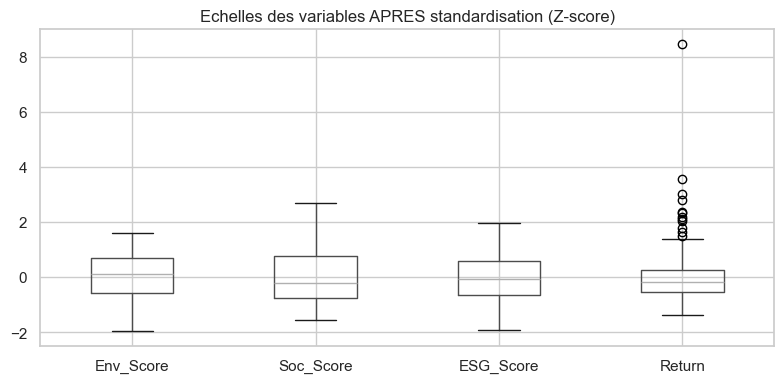

In [33]:
plt.figure(figsize=(8,4))
X_df.boxplot()
plt.title('Echelles des variables APRES standardisation (Z-score)')
plt.tight_layout()
plt.show()


### Effet de la standardisation (Z-score)

Apres standardisation, chaque variable contribue de maniere comparable aux distances.
C'est une condition necessaire pour tester proprement la relation ESG-rendements.


## 5) Visualisations ESG vs rendements

Objectif : voir si les rendements semblent se structurer selon les niveaux ESG.

On ajoute :
- Correlation ESG/rendement
- Scatter avec tendance
- Rendement moyen par quartile ESG
- Serie temporelle annuelle moyenne ESG vs rendement


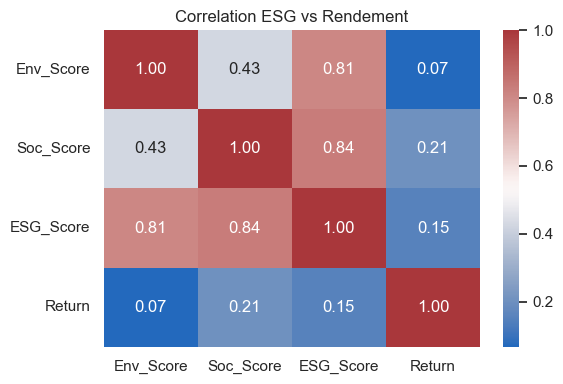

In [34]:
# Correlation simple entre ESG et rendement
corr = panel[['Env_Score','Soc_Score','ESG_Score','Return']].corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='vlag', fmt='.2f')
plt.title('Correlation ESG vs Rendement')
plt.tight_layout()
plt.show()

### Interpretation de la correlation

La matrice de corrélation mesure l’association linéaire moyenne entre les scores ESG et les rendements. Les corrélations observées sont faibles (entre 0.07 et 0.21), suggérant l’absence de relation linéaire forte inconditionnelle dans l’échantillon.
Toutefois, cette mesure reste purement descriptive : elle ne capture ni les non-linéarités potentielles, ni les effets sectoriels, ni les variations selon les régimes de marché.
De plus, dans un contexte de données panel, la corrélation agrège à la fois des effets inter-entreprises et intra-temporels, ce qui limite son interprétation structurelle ou causale.


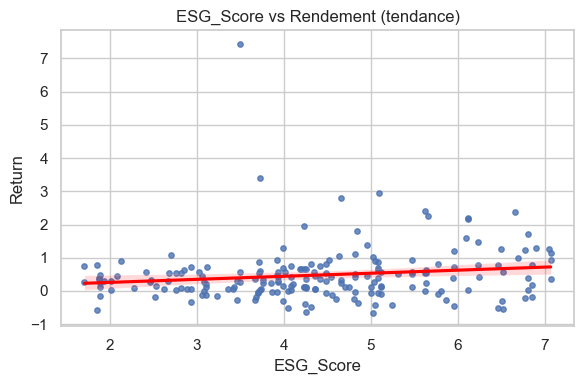

In [35]:
# Scatter ESG_Score vs Return avec tendance
plt.figure(figsize=(6,4))
sns.regplot(data=panel, x='ESG_Score', y='Return', scatter_kws={'s':15}, line_kws={'color':'red'})
plt.title('ESG_Score vs Rendement (tendance)')
plt.tight_layout()
plt.show()


### Lecture du scatter + tendance

Le nuage de points met en évidence une relation positive mais faible entre le score ESG et les rendements. La dispersion importante des observations indique que le score ESG n’explique qu’une faible part de la variabilité des rendements. Cette analyse reste descriptive et ne permet pas d’inférer une relation causale, notamment en raison de la structure panel des données et de l’absence de contrôle pour des effets sectoriels ou temporels.


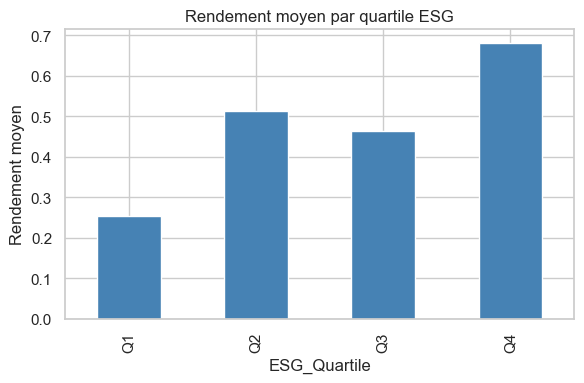

In [36]:
# Rendement moyen par quartile ESG
panel['ESG_Quartile'] = pd.qcut(panel['ESG_Score'], 4, labels=['Q1','Q2','Q3','Q4'])
quartile_mean = panel.groupby('ESG_Quartile')['Return'].mean().reindex(['Q1','Q2','Q3','Q4'])
plt.figure(figsize=(6,4))
quartile_mean.plot(kind='bar', color='steelblue')
plt.title('Rendement moyen par quartile ESG')
plt.ylabel('Rendement moyen')
plt.tight_layout()
plt.show()


### Quartiles ESG

L’analyse par quartiles ESG met en évidence une relation monotone globale entre score ESG et rendement moyen. Les entreprises appartenant au quartile supérieur (Q4) présentent un rendement moyen supérieur à celles du quartile inférieur (Q1).
Toutefois, cette analyse reste descriptive et ne contrôle ni les effets fixes d’entreprise ni les variations temporelles, ce qui limite son interprétation causale.


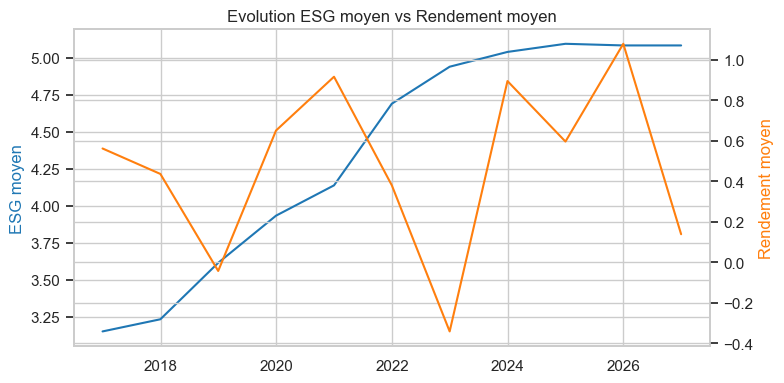

In [37]:
# Serie temporelle moyenne ESG vs rendement
ts = panel.groupby('Date')[['ESG_Score','Return']].mean().reset_index()
fig, ax1 = plt.subplots(figsize=(8,4))
ax1.plot(ts['Date'], ts['ESG_Score'], color='tab:blue', label='ESG moyen')
ax1.set_ylabel('ESG moyen', color='tab:blue')
ax2 = ax1.twinx()
ax2.plot(ts['Date'], ts['Return'], color='tab:orange', label='Rendement moyen')
ax2.set_ylabel('Rendement moyen', color='tab:orange')
plt.title('Evolution ESG moyen vs Rendement moyen')
plt.tight_layout()
plt.show()

### Serie temporelle annuelle ESG vs rendement

L’évolution temporelle du score ESG moyen montre une tendance haussière quasi monotone sur la période étudiée, reflétant soit une amélioration progressive des pratiques ESG, soit un effet méthodologique du fournisseur de données.
En revanche, le rendement moyen présente une forte volatilité et ne semble pas suivre la même dynamique.
Aucune relation temporelle évidente n’apparaît entre les deux séries à l’échelle agrégée.

## 6) K-means : methode du coude et silhouette

On combine deux criteres :
- Inertie (methode du coude)
- Silhouette (cohesion/separation)


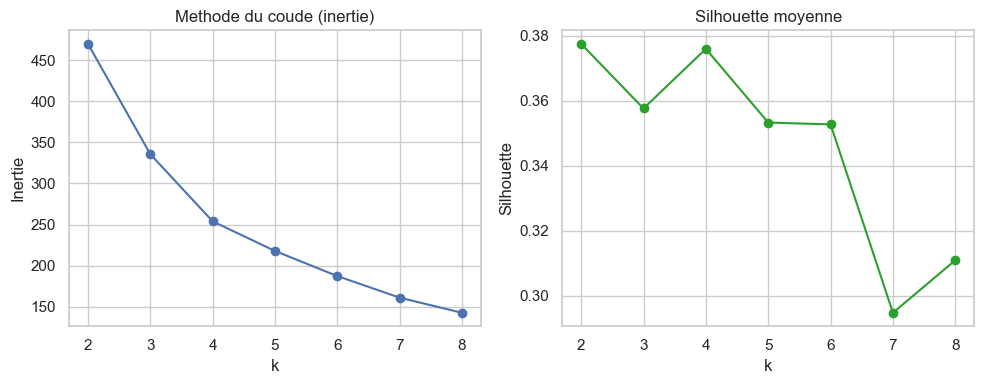

In [38]:
inertias = []
sil_scores = []
ks = range(2, 9)

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(list(ks), inertias, marker='o')
ax[0].set_title('Methode du coude (inertie)')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertie')

ax[1].plot(list(ks), sil_scores, marker='o', color='tab:green')
ax[1].set_title('Silhouette moyenne')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette')

plt.tight_layout()
plt.show()


### Choix de k (coude + silhouette)

La méthode du coude suggère un point d’inflexion autour de k=4, tandis que le score de silhouette atteint son maximum pour k=2, avec une valeur proche pour k=4.
Les valeurs de silhouette (≈0.37) indiquent une structure modérée mais non fortement séparée.

In [52]:
best_k = ks[int(np.argmax(sil_scores))]
best_k


2

### Interpretation du k retenu

Le k selectionne est celui qui maximise la silhouette.
Analyse critique : un k=2 peut etre trop grossier pour un papier si l'objectif est une
segmentation fine. Il faut alors justifier ce choix ou explorer des k alternatifs.


## 7) K-means final et visualisation (PCA)


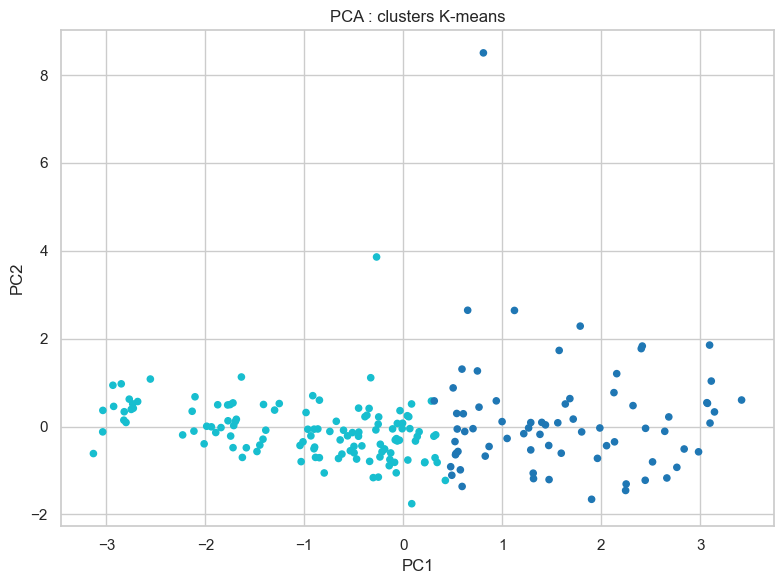

In [40]:
km = KMeans(n_clusters=best_k, n_init=10, random_state=42)
panel['Cluster_KMeans'] = km.fit_predict(X)

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(Z[:,0], Z[:,1], c=panel['Cluster_KMeans'], cmap='tab10', s=20)
plt.title('PCA : clusters K-means')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


### Lecture de la PCA coloree par K-means

La projection PCA met en évidence une séparation des observations principalement le long de la première composante principale (PC1), suggérant une structure quasi unidimensionnelle des données.
Compte tenu de la forte corrélation entre les composantes ESG (Env, Soc et ESG global), cette première composante semble capturer un facteur ESG commun dominant.
Le rendement apparaît secondaire dans la structuration des clusters, ce qui indique que la segmentation obtenue reflète principalement des niveaux relatifs de performance ESG plutôt qu’une typologie combinant fortement ESG et rendement.


In [41]:
# Profilage des clusters (moyennes standardisees)
cluster_profile = panel.groupby('Cluster_KMeans')[features].mean()
cluster_profile


,Env_Score,Soc_Score,ESG_Score,Return
Cluster_KMeans,,,,
0,5.640411,5.067123,5.769315,0.790453
1,3.356803,2.240902,3.552295,0.289815


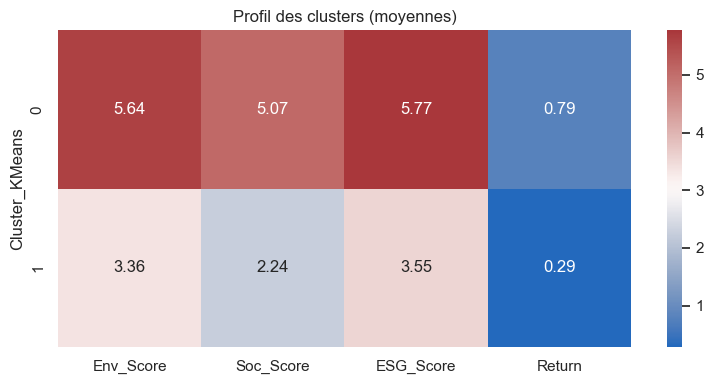

In [42]:
plt.figure(figsize=(8,4))
sns.heatmap(cluster_profile, annot=True, fmt='.2f', cmap='vlag')
plt.title('Profil des clusters (moyennes)')
plt.tight_layout()
plt.show()


### Profil des clusters

Le clustering KMeans (k=2) met en évidence deux groupes distincts : un cluster caractérisé par des scores ESG élevés et un rendement moyen supérieur (0.79), et un cluster à ESG plus faible associé à un rendement moyen plus modéré (0.29).
Cette segmentation suggère l’existence d’une différenciation structurelle entre entreprises à forte performance ESG et celles à performance ESG plus faible, avec un écart de rendement économiquement significatif.
Toutefois, cette relation reste descriptive et peut refléter des effets sectoriels, de taille ou des caractéristiques fixes d’entreprise non contrôlées.


## 8) Regressions simples (effet ESG sur rendement)

On estime l'effet moyen ESG -> rendement :
- Modele 1: Return ~ ESG
- Modele 2: Return ~ ESG + Env + Soc (attention: colinearite avec ESG)
- Modele 3: Return ~ ESG + effets temporels (annee)


In [49]:
import statsmodels.api as sm

# Assurer les types numeriques
panel['Return'] = pd.to_numeric(panel['Return'], errors='coerce')
panel['ESG_Score'] = pd.to_numeric(panel['ESG_Score'], errors='coerce')
panel['Env_Score'] = pd.to_numeric(panel['Env_Score'], errors='coerce')
panel['Soc_Score'] = pd.to_numeric(panel['Soc_Score'], errors='coerce')

# Modele 1
X1 = sm.add_constant(panel['ESG_Score'])
m1 = sm.OLS(panel['Return'], X1, missing='drop').fit(cov_type='HC3')

# Modele 2
X2 = sm.add_constant(panel[['ESG_Score','Env_Score','Soc_Score']])
m2 = sm.OLS(panel['Return'], X2, missing='drop').fit(cov_type='HC3')

# Modele 3: effets temporels (annee)
panel['Year'] = panel['Date'].dt.year
year_dummies = pd.get_dummies(panel['Year'], prefix='Year', drop_first=True).astype(float)
X3 = pd.concat([panel[['ESG_Score']], year_dummies], axis=1)
X3 = sm.add_constant(X3)
m3 = sm.OLS(panel['Return'], X3, missing='drop').fit(cov_type='HC3')

summary_table = pd.DataFrame({
    'coef_ESG': [m1.params.get('ESG_Score'), m2.params.get('ESG_Score'), m3.params.get('ESG_Score')],
    'p_ESG': [m1.pvalues.get('ESG_Score'), m2.pvalues.get('ESG_Score'), m3.pvalues.get('ESG_Score')],
    'R2': [m1.rsquared, m2.rsquared, m3.rsquared],
}, index=['Model1','Model2','Model3'])
summary_table


,coef_ESG,p_ESG,R2
Model1,0.091890,0.011258,0.023670
Model2,-0.074192,0.771670,0.043391
Model3,0.112192,0.008899,0.277669


### Lecture des regressions

Le modèle linéaire simple montre un effet positif et significatif du score ESG sur les rendements (β ≈ 0.092, p < 0.05).
Lorsque l’on contrôle les effets temporels annuels, le coefficient ESG reste positif et significatif (β ≈ 0.112, p < 0.01), suggérant que la relation observée ne s’explique pas uniquement par des tendances macroéconomiques communes.
En revanche, l’inclusion simultanée des composantes ESG (Env, Soc) entraîne une forte multicolinéarité et rend les coefficients instables.


## Conclusion generale

### Synthese
- Les analyses descriptives (corrélation, quartiles) mettent en évidence une association positive mais modérée entre le score ESG et les rendements, accompagnée d’une forte dispersion des observations.
- clustering K-means (k = 2) identifie principalement une différenciation selon le niveau ESG, avec un groupe à ESG élevé présentant un rendement moyen supérieur. La structure observée suggère davantage un gradient ESG continu qu’une segmentation fortement structurée.
- régressions linéaires confirment un effet positif et statistiquement significatif du score ESG sur les rendements. Cet effet persiste après introduction d’effets temporels annuels, ce qui indique qu’il ne s’explique pas uniquement par des tendances macroéconomiques communes. Toutefois, la part de variance expliquée directement par ESG demeure limitée.

### Limites
- Taille d’échantillon restreinte (18 entreprises) et présence de données manquantes pour certains tickers.
- Absence de contrôle pour des effets fixes entreprise et pour des facteurs financiers classiques (taille, bêta, momentum, secteur).
- Hypothèse d’indépendance potentiellement violée dans les tests statistiques appliqués aux données panel.
- Sensibilité possible aux choix de période et aux spécifications du modèle.

### Implications
- Les résultats suggèrent l’existence d’une association positive mais modérée entre ESG et performance moyenne.
- L’analyse ne permet pas d’établir une relation causale, mais met en évidence un signal cohérent à travers plusieurs approches descriptives et économétriques.
- Une validation plus robuste nécessiterait un panel élargi, l’introduction d’effets fixes entreprise et l’intégration de facteurs de risque financiers standards.

